In [1]:
#imports

import string
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingRegressor, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

import nltk

# Versions:
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'scikit-learn version: {skl.__version__}')
print(f'nltk version: {nltk.__version__}')


numpy version: 1.20.3
pandas version: 1.2.3
scikit-learn version: 0.23.2
nltk version: 3.6.7


Read data

In [2]:
STATE = 2022
#%matplotlib inline

In [3]:
raw_df = pd.read_csv('spam.csv')
raw_df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will �_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
raw_df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [5]:
raw_df.v1.sort_values().unique()

array(['ham', 'spam'], dtype=object)

In [6]:
raw_df.v2.values

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       ..., 'Pity, * was in mood for that. So...any other suggestions?',
       "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free",
       'Rofl. Its true to its name'], dtype=object)

In [7]:
raw_df.iloc[:,2].sort_values().count()


50

In [8]:
raw_df.iloc[:,3].sort_values().count()


12

In [9]:
raw_df.iloc[:,4].sort_values().count()

6

feature engineering

In [10]:
sms = raw_df.copy(deep=True)

In [11]:
sms.drop(sms.columns[2:], axis=1, inplace=True)
sms

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will �_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [12]:
sms.rename(columns={'v1':'type', 'v2':'message'}, inplace=True)
sms.head()

,type,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# encode (spam,ham) to (1,0)  
sms['type'] = np.where(sms['type']=='spam', 1, 0)
sms.head()

,type,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


sms linguistics - feature extraction

In [14]:
sms['length'] = sms['message'].str.len() - sms['message'].str.findall('\W+').apply(lambda x: len(x))
sms.head()

,type,message,length
0,0,"Go until jurong point, crazy.. Available only ...",91
1,0,Ok lar... Joking wif u oni...,23
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,123
3,0,U dun say so early hor... U c already then say...,38
4,0,"Nah I don't think he goes to usf, he lives aro...",48


In [15]:
vowels_ptn = '[aeiouAEIOU]'
consonants_ptn = '[b-df-hj-np-tv-z]'
digits_ptn = '\d'
punctuations_ptn = '[“”’\-(),:;!?.]'
capitalized_ptn = '[A-Z][a-z]+'
all_caps_ptn = '[A-Z\s]'
emojis_ptn = '(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])'
symbols_ptn = '['+string.punctuation+']'

sms['vowels'] = sms['message'].str.findall(vowels_ptn).apply(lambda x: len(x))/sms['length']
sms['consonants'] = sms['message'].str.findall(consonants_ptn).apply(lambda x: len(x))/sms['length']
sms['digits'] = sms['message'].str.findall(digits_ptn).apply(lambda x: len(x))/sms['length']
sms['punctuations'] = sms['message'].str.findall(punctuations_ptn).apply(lambda x: len(x))/sms['length']
sms['capitalized'] = sms['message'].str.findall(capitalized_ptn).apply(lambda x: len(x))/sms['length']
sms['all_caps'] = sms['message'].str.findall(all_caps_ptn).apply(lambda x: len(x))/sms['length']
sms['emojis'] = sms['message'].str.findall(emojis_ptn).apply(lambda x: len(x))/sms['length']
sms['symbols'] = sms['message'].str.findall(symbols_ptn).apply(lambda x: len(x))/sms['length']

sms.head()

,type,message,length,vowels,consonants,digits,punctuations,capitalized,all_caps,emojis,symbols
0,0,"Go until jurong point, crazy.. Available only ...",91,0.362637,0.527473,0.000000,0.098901,0.032967,0.241758,0.0,0.098901
1,0,Ok lar... Joking wif u oni...,23,0.347826,0.391304,0.000000,0.260870,0.086957,0.304348,0.0,0.260870
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,123,0.252033,0.471545,0.203252,0.024390,0.032520,0.300813,0.0,0.048780
3,0,U dun say so early hor... U c already then say...,38,0.342105,0.526316,0.000000,0.157895,0.000000,0.315789,0.0,0.157895
4,0,"Nah I don't think he goes to usf, he lives aro...",48,0.395833,0.562500,0.000000,0.020833,0.020833,0.291667,0.0,0.041667


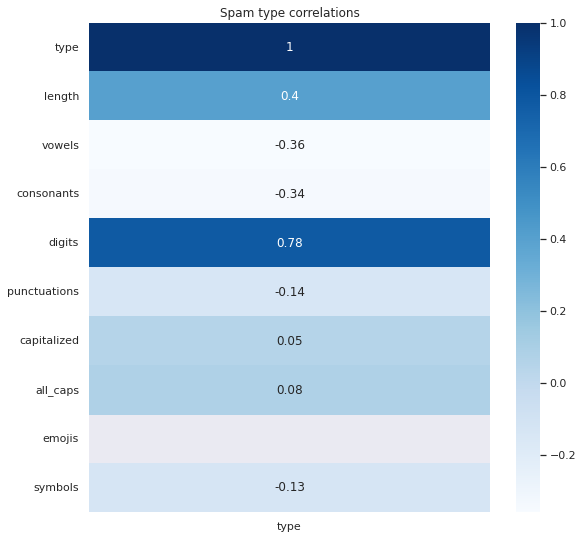

In [16]:
corr_mat = sms.corr()[['type']].round(2)

sns.set(rc = {'figure.figsize':(9,9)})
sns.heatmap(corr_mat, cmap='Blues', annot=True)
plt.title('Spam type correlations')
plt.savefig('spam_corr.svg')
plt.show()


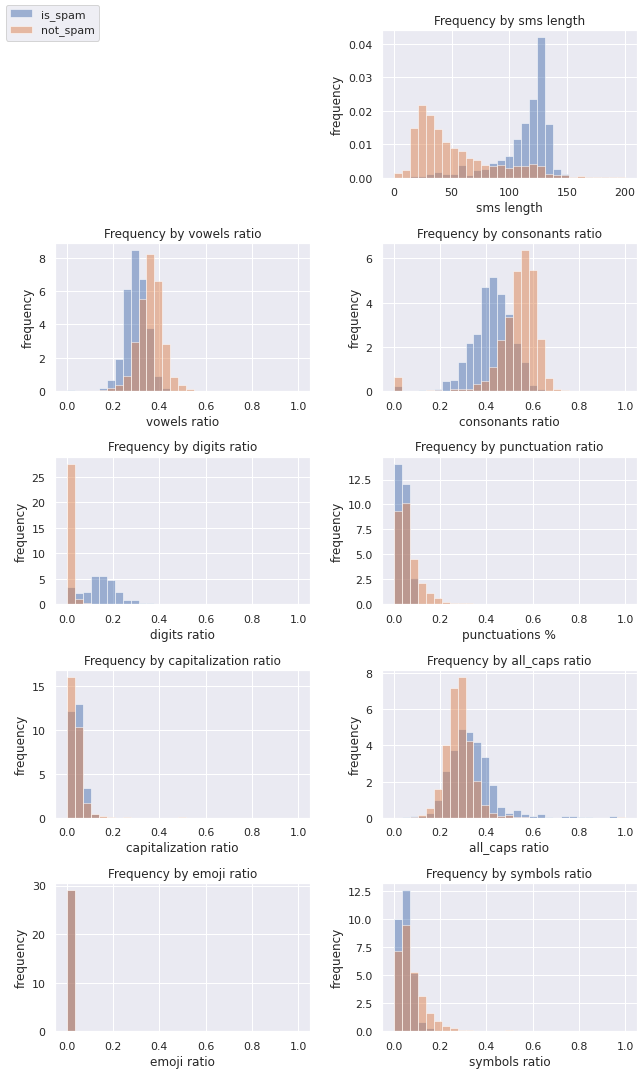

In [17]:
fig, ax = plt.subplots(5,2, figsize=(9,15))


### sms length
ax[0,1].set_title('Frequency by sms length')
ax[0,1].set_xlabel('sms length')
ax[0,1].set_ylabel('frequency')

lenght_bins = np.linspace(0,200, 30)

ax[0,1].hist(sms[sms['type']==1]['length'],
            lenght_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[0,1].hist(sms[sms['type']==0]['length'],
            lenght_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### vowels %

ax[1,0].set_title('Frequency by vowels ratio')
ax[1,0].set_xlabel('vowels ratio')
ax[1,0].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[1,0].hist(sms[sms['type']==1]['vowels'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[1,0].hist(sms[sms['type']==0]['vowels'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### consonants %

ax[1,1].set_title('Frequency by consonants ratio')
ax[1,1].set_xlabel('consonants ratio')
ax[1,1].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[1,1].hist(sms[sms['type']==1]['consonants'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[1,1].hist(sms[sms['type']==0]['consonants'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### digits %

ax[2,0].set_title('Frequency by digits ratio')
ax[2,0].set_xlabel('digits ratio')
ax[2,0].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[2,0].hist(sms[sms['type']==1]['digits'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[2,0].hist(sms[sms['type']==0]['digits'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### punctuations %

ax[2,1].set_title('Frequency by punctuation ratio')
ax[2,1].set_xlabel('punctuations %')
ax[2,1].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[2,1].hist(sms[sms['type']==1]['punctuations'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[2,1].hist(sms[sms['type']==0]['punctuations'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### capitalized %

ax[3,0].set_title('Frequency by capitalization ratio')
ax[3,0].set_xlabel('capitalization ratio')
ax[3,0].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[3,0].hist(sms[sms['type']==1]['capitalized'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[3,0].hist(sms[sms['type']==0]['capitalized'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )


### all_caps %

ax[3,1].set_title('Frequency by all_caps ratio')
ax[3,1].set_xlabel('all_caps ratio')
ax[3,1].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[3,1].hist(sms[sms['type']==1]['all_caps'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[3,1].hist(sms[sms['type']==0]['all_caps'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### emoji %

ax[4,0].set_title('Frequency by emoji ratio')
ax[4,0].set_xlabel('emoji ratio')
ax[4,0].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[4,0].hist(sms[sms['type']==1]['emojis'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[4,0].hist(sms[sms['type']==0]['emojis'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )


### all_caps %

ax[4,1].set_title('Frequency by symbols ratio')
ax[4,1].set_xlabel('symbols ratio')
ax[4,1].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[4,1].hist(sms[sms['type']==1]['symbols'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[4,1].hist(sms[sms['type']==0]['symbols'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )


###

plt.tight_layout()

fig.legend(['is_spam','not_spam'], loc='upper left')
fig.delaxes(ax[0,0])
plt.savefig('features.svg')
plt.show()


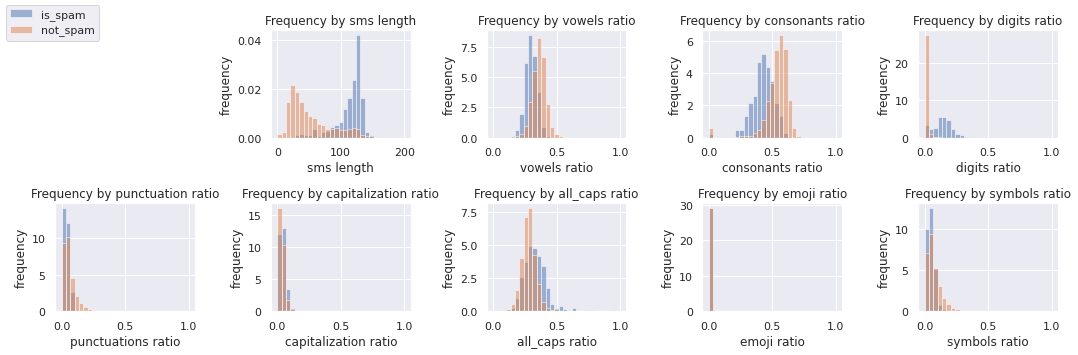

In [18]:
fig, ax = plt.subplots(2, 5, figsize=(15,5))


### sms length
ax[0,1].set_title('Frequency by sms length')
ax[0,1].set_xlabel('sms length')
ax[0,1].set_ylabel('frequency')

lenght_bins = np.linspace(0,200, 30)

ax[0,1].hist(sms[sms['type']==1]['length'],
            lenght_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[0,1].hist(sms[sms['type']==0]['length'],
            lenght_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### vowels %

ax[0,2].set_title('Frequency by vowels ratio')
ax[0,2].set_xlabel('vowels ratio')
ax[0,2].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[0,2].hist(sms[sms['type']==1]['vowels'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[0,2].hist(sms[sms['type']==0]['vowels'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### consonants %

ax[0,3].set_title('Frequency by consonants ratio')
ax[0,3].set_xlabel('consonants ratio')
ax[0,3].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[0,3].hist(sms[sms['type']==1]['consonants'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[0,3].hist(sms[sms['type']==0]['consonants'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### digits %

ax[0,4].set_title('Frequency by digits ratio')
ax[0,4].set_xlabel('digits ratio')
ax[0,4].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[0,4].hist(sms[sms['type']==1]['digits'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[0,4].hist(sms[sms['type']==0]['digits'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### punctuations %

ax[1,0].set_title('Frequency by punctuation ratio')
ax[1,0].set_xlabel('punctuations ratio')
ax[1,0].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[1,0].hist(sms[sms['type']==1]['punctuations'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[1,0].hist(sms[sms['type']==0]['punctuations'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### capitalized %

ax[1,1].set_title('Frequency by capitalization ratio')
ax[1,1].set_xlabel('capitalization ratio')
ax[1,1].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[1,1].hist(sms[sms['type']==1]['capitalized'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[1,1].hist(sms[sms['type']==0]['capitalized'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )


### all_caps %

ax[1,2].set_title('Frequency by all_caps ratio')
ax[1,2].set_xlabel('all_caps ratio')
ax[1,2].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[1,2].hist(sms[sms['type']==1]['all_caps'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[1,2].hist(sms[sms['type']==0]['all_caps'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )

### emoji %

ax[1,3].set_title('Frequency by emoji ratio')
ax[1,3].set_xlabel('emoji ratio')
ax[1,3].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[1,3].hist(sms[sms['type']==1]['emojis'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[1,3].hist(sms[sms['type']==0]['emojis'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )


### all_caps %

ax[1,4].set_title('Frequency by symbols ratio')
ax[1,4].set_xlabel('symbols ratio')
ax[1,4].set_ylabel('frequency')

vowels_bins = np.linspace(0,1, 30)

ax[1,4].hist(sms[sms['type']==1]['symbols'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='is_spam'
           )
ax[1,4].hist(sms[sms['type']==0]['symbols'],
            vowels_bins,
            alpha=0.5,
            density=True,
            label='not_spam'
           )


###

plt.tight_layout()

fig.legend(['is_spam','not_spam'], loc='upper left')
fig.delaxes(ax[0,0])
plt.savefig('features2.png')
plt.show()


In [19]:
#sms unique characteristics df
scaler = MinMaxScaler(copy=False)
sms[sms.columns.difference(['type','message'])] = scaler.fit_transform(sms[sms.columns.difference(['type','message'])])
sms.head()

,type,message,length,vowels,consonants,digits,punctuations,capitalized,all_caps,emojis,symbols
0,0,"Go until jurong point, crazy.. Available only ...",0.123955,0.483516,0.644689,0.000000,0.098901,0.065934,0.175824,0.0,0.098901
1,0,Ok lar... Joking wif u oni...,0.029248,0.463768,0.478261,0.000000,0.260870,0.173913,0.221344,0.0,0.260870
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.168524,0.336043,0.576332,0.203252,0.024390,0.065041,0.218773,0.0,0.048780
3,0,U dun say so early hor... U c already then say...,0.050139,0.456140,0.643275,0.000000,0.157895,0.000000,0.229665,0.0,0.157895
4,0,"Nah I don't think he goes to usf, he lives aro...",0.064067,0.527778,0.687500,0.000000,0.020833,0.041667,0.212121,0.0,0.041667


vectorizing

cleaning messages

In [20]:
# clean up
stopwords = nltk.corpus.stopwords.words('english')

def clean_up(msg):
    msg = msg.translate(str.maketrans('', '', string.punctuation))
    tkns = re.split('\W+', msg)
    msg = [ word for word in tkns if word not in stopwords]
    return msg

sms['clean_message'] = sms['message'].apply(lambda x: clean_up(x))
sms.drop('message', axis=1, inplace=True)
print(f'sms shape: {sms.shape}')
sms.head()

sms shape: (5572, 11)


,type,length,vowels,consonants,digits,punctuations,capitalized,all_caps,emojis,symbols,clean_message
0,0,0.123955,0.483516,0.644689,0.000000,0.098901,0.065934,0.175824,0.0,0.098901,"[Go, jurong, point, crazy, Available, bugis, n..."
1,0,0.029248,0.463768,0.478261,0.000000,0.260870,0.173913,0.221344,0.0,0.260870,"[Ok, lar, Joking, wif, u, oni]"
2,1,0.168524,0.336043,0.576332,0.203252,0.024390,0.065041,0.218773,0.0,0.048780,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,0,0.050139,0.456140,0.643275,0.000000,0.157895,0.000000,0.229665,0.0,0.157895,"[U, dun, say, early, hor, U, c, already, say]"
4,0,0.064067,0.527778,0.687500,0.000000,0.020833,0.041667,0.212121,0.0,0.041667,"[Nah, I, dont, think, goes, usf, lives, around..."


splitting into (feature, target) (train, validate, test)

In [21]:
x = sms[sms.columns.difference(['type'])]
y = sms['type']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.4)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val,test_size=0.5)

print(f'x size:{x.shape}, y size:{y.shape}')
print('------')
print(f'x_train size:{x_train.shape}, y_train size:{y_train.shape}')
print(f'x_val size:{x_val.shape}, y_val size:{y_val.shape}')
print(f'x_test size:{x_test.shape}, y_test size:{y_test.shape}')
print('------')
x_train.head()

x size:(5572, 10), y size:(5572,)
------
x_train size:(3343, 10), y_train size:(3343,)
x_val size:(1114, 10), y_val size:(1114,)
x_test size:(1115, 10), y_test size:(1115,)
------


,all_caps,capitalized,clean_message,consonants,digits,emojis,length,punctuations,symbols,vowels
5292,0.227273,0.109375,"[Urgent, Please, call, 09061213237, landline, ...",0.467882,0.210938,0.0,0.175487,0.046875,0.070312,0.343750
2604,0.210101,0.044444,"[You, call, times, job, today, ok, umma, ask, ...",0.706173,0.000000,0.0,0.059889,0.000000,0.000000,0.533333
1117,0.153110,0.070175,"[449050000301, You, 2000, price, To, claim, ca...",0.278752,0.473684,0.0,0.076602,0.070175,0.070175,0.280702
1495,0.205534,0.086957,"[Hey, gals, Anyone, u, going, e, driving, cent...",0.717391,0.000000,0.0,0.061281,0.065217,0.065217,0.463768
215,0.133581,0.040816,"[Finally, match, heading, towards, draw, predi...",0.773243,0.000000,0.0,0.065460,0.020408,0.020408,0.462585


sms linguistics features

In [22]:
x_train_lf = x_train[x_train.columns.difference(['clean_message'])].copy(deep=True)
x_val_lf = x_val[x_val.columns.difference(['clean_message'])].copy(deep=True)
x_test_lf = x_test[x_test.columns.difference(['clean_message'])].copy(deep=True)

print(f'x_train_lf size:{x_train_lf.shape}, y_train size:{y_train.shape}')
print(f'x_val_lf size:{x_val_lf.shape}, y_val size:{y_val.shape}')
print(f'x_test_lf size:{x_test_lf.shape}, y_test size:{y_test.shape}')
print('------')
x_train_lf.head()

x_train_lf size:(3343, 9), y_train size:(3343,)
x_val_lf size:(1114, 9), y_val size:(1114,)
x_test_lf size:(1115, 9), y_test size:(1115,)
------


,all_caps,capitalized,consonants,digits,emojis,length,punctuations,symbols,vowels
5292,0.227273,0.109375,0.467882,0.210938,0.0,0.175487,0.046875,0.070312,0.343750
2604,0.210101,0.044444,0.706173,0.000000,0.0,0.059889,0.000000,0.000000,0.533333
1117,0.153110,0.070175,0.278752,0.473684,0.0,0.076602,0.070175,0.070175,0.280702
1495,0.205534,0.086957,0.717391,0.000000,0.0,0.061281,0.065217,0.065217,0.463768
215,0.133581,0.040816,0.773243,0.000000,0.0,0.065460,0.020408,0.020408,0.462585


sms TFIDF vectors

In [23]:
tfidf = TfidfVectorizer()
tfidf.fit(x_train.clean_message.astype(str))
x_train_tfidf = tfidf.transform(x_train.clean_message.astype(str))
x_val_tfidf = tfidf.transform(x_val.clean_message.astype(str))
x_test_tfidf = tfidf.transform(x_test.clean_message.astype(str))

print(f'x_train_tfidf size:{x_train_tfidf.shape}, y_train size:{y_train.shape}')
print(f'x_val_tfidf size:{x_val_tfidf.shape}, y_val size:{y_val.shape}')
print(f'x_test_tfidf size:{x_test_tfidf.shape}, y_test size:{y_test.shape}')
print('------')
x_train_tfidf.toarray()

x_train_tfidf size:(3343, 7151), y_train size:(3343,)
x_val_tfidf size:(1114, 7151), y_val size:(1114,)
x_test_tfidf size:(1115, 7151), y_test size:(1115,)
------


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

sms linguistics features and TFIDF vectors

In [24]:
x_train_lf_tfidf = x_train_lf.join(pd.DataFrame(x_train_tfidf.toarray()))
x_val_lf_tfidf = x_val_lf.join(pd.DataFrame(x_val_tfidf.toarray()))
x_test_lf_tfidf = x_test_lf.join(pd.DataFrame(x_test_tfidf.toarray()))

x_train_lf_tfidf.fillna(0.0, inplace=True)
x_val_lf_tfidf.fillna(0.0, inplace=True)
x_test_lf_tfidf.fillna(0.0, inplace=True)

print(f'x_train_lf_tfidf size:{x_train_lf_tfidf.shape}, y_train size:{y_train.shape}')
print(f'x_val_lf_tfidf size:{x_val_lf_tfidf.shape}, y_val size:{y_val.shape}')
print(f'x_test_lf_tfidf size:{x_test_lf_tfidf.shape}, y_test size:{y_test.shape}')
x_train_lf_tfidf.head()

x_train_lf_tfidf size:(3343, 7160), y_train size:(3343,)
x_val_lf_tfidf size:(1114, 7160), y_val size:(1114,)
x_test_lf_tfidf size:(1115, 7160), y_test size:(1115,)


,all_caps,capitalized,consonants,digits,emojis,length,punctuations,symbols,vowels,0,...,7141,7142,7143,7144,7145,7146,7147,7148,7149,7150
5292,0.227273,0.109375,0.467882,0.210938,0.0,0.175487,0.046875,0.070312,0.343750,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2604,0.210101,0.044444,0.706173,0.000000,0.0,0.059889,0.000000,0.000000,0.533333,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1117,0.153110,0.070175,0.278752,0.473684,0.0,0.076602,0.070175,0.070175,0.280702,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1495,0.205534,0.086957,0.717391,0.000000,0.0,0.061281,0.065217,0.065217,0.463768,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0.133581,0.040816,0.773243,0.000000,0.0,0.065460,0.020408,0.020408,0.462585,0.0,...,0.30091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

modeling

In [25]:
results = pd.DataFrame(columns=['extraction_type', 'applied_algorithm', 'accuracy', 'precision', 'recall'])
results.columns

Index(['extraction_type', 'applied_algorithm', 'accuracy', 'precision',
       'recall'],
      dtype='object')

Support Vector Machine

In [26]:
# sms linguistics and Support Vector Machine

svc = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': np.arange(0.07, 0.11, 0.01) #[0.1, 1, 10]
}

svc_cv = GridSearchCV(svc, parameters, cv=5)
svc_cv.fit(x_train_lf, y_train.values.ravel())
svc_model = svc_cv.best_estimator_
print(svc_model)
y_pred = svc_model.predict(x_val_lf)

accuracy = accuracy_score(y_val, y_pred).round(2)
precision = precision_score(y_val, y_pred).round(2)
recall = recall_score(y_val, y_pred).round(2)

print(f'prediction using sms linguistics and Support Vector Machine:')
print(f'accuracy = {accuracy:.2%}')
print(f'precision = {precision:.2%}')
print(f'recall = {recall:.2%}')

results.loc[len(results.index)] = ['sms linguistics', 'Support Vector Machine', accuracy, precision, recall]


SVC(C=0.09999999999999999)
prediction using sms linguistics and Support Vector Machine:
accuracy = 97.00%
precision = 96.00%
recall = 80.00%


In [27]:
# TFIDF and Support Vector Machine

svc = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': np.arange(0.07, 0.11, 0.01) #[0.1, 1, 10]
}

svc_cv = GridSearchCV(svc, parameters, cv=5)
svc_cv.fit(x_train_tfidf, y_train.values.ravel())
svc_model = svc_cv.best_estimator_
print(svc_model)
y_pred = svc_model.predict(x_val_tfidf)

accuracy = accuracy_score(y_val, y_pred).round(2)
precision = precision_score(y_val, y_pred).round(2)
recall = recall_score(y_val, y_pred).round(2)

print(f'prediction using TFIDF and Support Vector Machine')
print(f'accuracy = {accuracy:.2%}')
print(f'precision = {precision:.2%}')
print(f'recall = {recall:.2%}')

results.loc[len(results.index)] = ['TFIDF', 'Support Vector Machine', accuracy, precision, recall]


SVC(C=0.09999999999999999, kernel='linear')
prediction using TFIDF and Support Vector Machine
accuracy = 93.00%
precision = 100.00%
recall = 39.00%


In [28]:
# sms linguistics, TFIDF and Support Vector Machine

svc = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': np.arange(0.07, 0.11, 0.01) #[0.1, 1, 10]
}

svc_cv = GridSearchCV(svc, parameters, cv=5)
svc_cv.fit(x_train_lf_tfidf, y_train.values.ravel())
svc_model = svc_cv.best_estimator_
print(svc_model)
y_pred = svc_model.predict(x_val_lf_tfidf)

accuracy = accuracy_score(y_val, y_pred).round(2)
precision = precision_score(y_val, y_pred).round(2)
recall = recall_score(y_val, y_pred).round(2)

print(f'prediction using sms linguistics, TFIDF and Support Vector Machine:')
print(f'accuracy = {accuracy:.2%}')
print(f'precision = {precision:.2%}')
print(f'recall = {recall:.2%}')

results.loc[len(results.index)] = ['sms linguistics and TFIDF', 'Support Vector Machine', accuracy, precision, recall]


SVC(C=0.09999999999999999, kernel='linear')
prediction using sms linguistics, TFIDF and Support Vector Machine:
accuracy = 95.00%
precision = 97.00%
recall = 58.00%


In [29]:
results

,extraction_type,applied_algorithm,accuracy,precision,recall
0,sms linguistics,Support Vector Machine,0.97,0.96,0.80
1,TFIDF,Support Vector Machine,0.93,1.00,0.39
2,sms linguistics and TFIDF,Support Vector Machine,0.95,0.97,0.58


RandomForestClassifier

In [30]:
# sms linguistics and Random Forest
rf = RandomForestClassifier()
parameters = {
    'max_depth': np.arange(5,9), #[2, 4, 8, 16, 32, None]
    'n_estimators': np.arange(210,240) #[5, 50, 250],
}

rf_cv = GridSearchCV(rf, parameters, cv=5)
rf_cv.fit(x_train_lf, y_train.values.ravel())
rf_model = rf_cv.best_estimator_
print(rf_model)
y_pred = rf_model.predict(x_val_lf)

accuracy = accuracy_score(y_val, y_pred).round(2)
precision = precision_score(y_val, y_pred).round(2)
recall = recall_score(y_val, y_pred).round(2)

print(f'prediction using sms linguistics and random-forest:')
print(f'accuracy = {accuracy:.2%}')
print(f'precision = {precision:.2%}')
print(f'recall = {recall:.2%}')

results.loc[len(results.index)] = ['sms linguistics', 'Random Forest', accuracy, precision, recall]


RandomForestClassifier(max_depth=8, n_estimators=225)
prediction using sms linguistics and random-forest:
accuracy = 98.00%
precision = 96.00%
recall = 86.00%


In [31]:
# TFIDF and Random Forest
rf = RandomForestClassifier()
parameters = {
    'max_depth': np.arange(5,9), #[2, 4, 8, 16, 32, None]
    'n_estimators': np.arange(210,230) #[5, 50, 250],
}

rf_cv = GridSearchCV(rf, parameters, cv=5)
rf_cv.fit(x_train_tfidf, y_train.values.ravel())
rf_model = rf_cv.best_estimator_
print(rf_model)
y_pred = rf_model.predict(x_val_tfidf)

accuracy = accuracy_score(y_val, y_pred).round(2)
precision = precision_score(y_val, y_pred).round(2)
recall = recall_score(y_val, y_pred).round(2)

print(f'prediction using TFIDF and Random Forest:')
print(f'accuracy = {accuracy:.2%}')
print(f'precision = {precision:.2%}')
print(f'recall = {recall:.2%}')

results.loc[len(results.index)] = ['TFIDF', 'Random Forest', accuracy, precision, recall]


RandomForestClassifier(max_depth=8, n_estimators=210)
prediction using TFIDF and Random Forest:
accuracy = 90.00%
precision = 100.00%
recall = 17.00%


In [32]:
# sms linguistic, TFIDF and Random Forest

rf = RandomForestClassifier()
parameters = {
    'max_depth': np.arange(5,9), #[2, 4, 8, 16, 32, None]
    'n_estimators': np.arange(240,260) #[5, 50, 250],
}

rf_cv = GridSearchCV(rf, parameters, cv=5)
rf_cv.fit(x_train_lf_tfidf, y_train.values.ravel())
rf_model = rf_cv.best_estimator_
print(rf_model)
y_pred = rf_model.predict(x_val_lf_tfidf)

accuracy = accuracy_score(y_val, y_pred).round(2)
precision = precision_score(y_val, y_pred).round(2)
recall = recall_score(y_val, y_pred).round(2)

print(f'prediction using sms linguistics, TFIDF and Random Forest:')
print(f'accuracy = {accuracy:.2%}')
print(f'precision = {precision:.2%}')
print(f'recall = {recall:.2%}')

results.loc[len(results.index)] = ['sms linguistics and TFIDF', 'Random Forest', accuracy, precision, recall]


RandomForestClassifier(max_depth=5, n_estimators=240)
prediction using sms linguistics, TFIDF and Random Forest:
accuracy = 88.00%
precision = 0.00%
recall = 0.00%


/home/richardmfitumukiza/anaconda3/envs/VI-ML_BI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
results

,extraction_type,applied_algorithm,accuracy,precision,recall
0,sms linguistics,Support Vector Machine,0.97,0.96,0.80
1,TFIDF,Support Vector Machine,0.93,1.00,0.39
2,sms linguistics and TFIDF,Support Vector Machine,0.95,0.97,0.58
3,sms linguistics,Random Forest,0.98,0.96,0.86
4,TFIDF,Random Forest,0.90,1.00,0.17
5,sms linguistics and TFIDF,Random Forest,0.88,0.00,0.00


Gradient Boost

In [34]:
# sms linguistics and Gradient Boosting

gb = GradientBoostingClassifier()
parameters = {
    'learning_rate': [0.01, 0.1, 1, 10, 100], # np.arange(0.01, 1, 0.01)
    'n_estimators': [5, 50, 250, 500], #np.arange(620,640) #
}

gb_cv = GridSearchCV(gb, parameters, cv=5)
gb_cv.fit(x_train_lf, y_train.values.ravel())
gb_model = gb_cv.best_estimator_
print(gb_model)
y_pred = gb_model.predict(x_val_lf)

accuracy = accuracy_score(y_val, y_pred)#.round(3)
precision = precision_score(y_val, y_pred)#.round(3)
recall = recall_score(y_val, y_pred)#.round(3)

print(f'prediction using sms linguistics and Gradient Boosting')
print(f'accuracy = {accuracy:.2%}')
print(f'precision = {precision:.2%}')
print(f'recall = {recall:.2%}')

results.loc[len(results.index)] = ['sms linguistics', 'Gradient Boosting', accuracy, precision, recall]


GradientBoostingClassifier(n_estimators=250)
prediction using sms linguistics and Gradient Boosting
accuracy = 98.03%
precision = 95.12%
recall = 87.97%


In [35]:
# TFIDF and Gradient Boosting

gb = GradientBoostingClassifier()
parameters = {
    'learning_rate': [0.01, 0.1, 1, 10, 100], # np.arange(0.01, 1, 0.01)
    'n_estimators': [5, 50, 250, 500], #np.arange(620,640) #
}

gb_cv = GridSearchCV(gb, parameters, cv=5)
gb_cv.fit(x_train_tfidf, y_train.values.ravel())
gb_model = gb_cv.best_estimator_
print(gb_model)
y_pred = gb_model.predict(x_val_tfidf)

accuracy = accuracy_score(y_val, y_pred)#.round(3)
precision = precision_score(y_val, y_pred)#.round(3)
recall = recall_score(y_val, y_pred)#.round(3)

print(f'prediction using TFIDF and Gradient Boosting')
print(f'accuracy = {accuracy:.2%}')
print(f'precision = {precision:.2%}')
print(f'recall = {recall:.2%}')

results.loc[len(results.index)] = ['TFIDF', 'Gradient Boosting', accuracy, precision, recall]


GradientBoostingClassifier(n_estimators=500)
prediction using TFIDF and Gradient Boosting
accuracy = 97.67%
precision = 96.52%
recall = 83.46%


In [36]:
# sms linguistics, TFIDF and Gradient Boosting

gb = GradientBoostingClassifier()
parameters = {
    'learning_rate': [0.01, 0.1, 1, 10, 100], # np.arange(0.01, 1, 0.01)
    'n_estimators': [5, 50, 250, 500], #np.arange(620,640) #
}

gb_cv = GridSearchCV(gb, parameters, cv=5)
gb_cv.fit(x_train_lf_tfidf, y_train.values.ravel())
gb_model = gb_cv.best_estimator_
print(gb_model)
y_pred = gb_model.predict(x_val_lf_tfidf)

accuracy = accuracy_score(y_val, y_pred)#.round(3)
precision = precision_score(y_val, y_pred)#.round(3)
recall = recall_score(y_val, y_pred)#.round(3)

print(f'prediction using sms linguistics, TFIDF and Gradient Boosting')
print(f'accuracy = {accuracy:.2%}')
print(f'precision = {precision:.2%}')
print(f'recall = {recall:.2%}')

results.loc[len(results.index)] = ['sms linguistics and TFIDF', 'Gradient Boosting', accuracy, precision, recall]


GradientBoostingClassifier(n_estimators=500)
prediction using sms linguistics, TFIDF and Gradient Boosting
accuracy = 98.03%
precision = 95.12%
recall = 87.97%


In [37]:
results

,extraction_type,applied_algorithm,accuracy,precision,recall
0,sms linguistics,Support Vector Machine,0.970000,0.960000,0.800000
1,TFIDF,Support Vector Machine,0.930000,1.000000,0.390000
2,sms linguistics and TFIDF,Support Vector Machine,0.950000,0.970000,0.580000
3,sms linguistics,Random Forest,0.980000,0.960000,0.860000
4,TFIDF,Random Forest,0.900000,1.000000,0.170000
5,sms linguistics and TFIDF,Random Forest,0.880000,0.000000,0.000000
6,sms linguistics,Gradient Boosting,0.980251,0.951220,0.879699
7,TFIDF,Gradient Boosting,0.976661,0.965217,0.834586
8,sms linguistics and TFIDF,Gradient Boosting,0.980251,0.951220,0.879699
